In [4]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from pycocotools.coco import COCO
import skimage.io as io
from tqdm.notebook import tqdm
import shutil

AUTOTUNE = tf.data.AUTOTUNE
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


In [5]:
print("--- 1. Setting up GPU and Paths ---")

# --- Constants ---
NUM_IMAGES_TO_PROCESS = 40000
IMG_HEIGHT = 256
IMG_WIDTH = 256
BATCH_SIZE = 32 

# --- TFRecord Setup ---
TFRECORD_DIR = "/kaggle/working/tfrecords"
TFRECORD_SHARDS = 16 # We'll split our data into 16 files
os.makedirs(TFRECORD_DIR, exist_ok=True)
print(f"Will save TFRecords to: {TFRECORD_DIR}")

# --- Original COCO data paths ---
dataDir = '/kaggle/input/coco-2017-dataset/coco2017'
dataType = 'train2017'
img_dir_original = os.path.join(dataDir, dataType)
annFile = os.path.join(dataDir, 'annotations', f'instances_{dataType}.json')

# --- Load COCO annotations ---
print("Loading annotations...")
coco = COCO(annFile)
print("Annotations loaded.")

# --- Get image IDs and paths ---
all_imgIds = coco.getImgIds()
imgIds_subset = all_imgIds[:NUM_IMAGES_TO_PROCESS]
print(f"Will process {len(imgIds_subset)} images.")

--- 1. Setting up GPU and Paths ---
Will save TFRecords to: /kaggle/working/tfrecords
Loading annotations...
loading annotations into memory...
Done (t=20.76s)
creating index...
index created!
Annotations loaded.
Will process 40000 images.


In [6]:
print("--- 2. Defining TFRecord Helper Functions (Byte-based) ---")

# --- Serialization Functions ---
# These convert our data into a format TFRecord can store

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # Get value out of EagerTensor
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(image_bytes, mask_bytes):
  """
  Creates a tf.train.Example message with raw image/mask bytes.
  """
  # Create a features dictionary
  feature = {
      'image': _bytes_feature(image_bytes),
      'mask': _bytes_feature(mask_bytes),
  }
  
  # Create a Features message using tf.train.Example
  example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
  return example_proto.SerializeToString()

print("Helper functions defined.")

--- 2. Defining TFRecord Helper Functions (Byte-based) ---
Helper functions defined.


In [7]:
print("--- 3. Creating TFRecord Files (with raw bytes) ---")
print("This will be much faster and save disk space.")

# --- Open all 16 file writers ---
writers = [
    tf.io.TFRecordWriter(
        os.path.join(TFRECORD_DIR, f"data_shard_{i:02d}.tfrecord")
    ) for i in range(TFRECORD_SHARDS)
]

for i, imgId in enumerate(tqdm(imgIds_subset, desc="Writing TFRecords")):
    try:
        # --- 1. Get Image Path ---
        img_info = coco.loadImgs([imgId])[0]
        img_path = os.path.join(img_dir_original, img_info['file_name'])
        
        if not os.path.exists(img_path):
            print(f"Warning: Missing file {img_path}")
            continue
        
        # --- 2. Load RAW Image Bytes ---
        image_bytes = tf.io.read_file(img_path)
        
        # --- 3. Generate Mask ---
        annIds = coco.getAnnIds(imgIds=imgId)
        anns = coco.loadAnns(annIds)
        height, width = img_info['height'], img_info['width']
        
        final_binary_mask = np.zeros((height, width), dtype=np.uint8)
        if anns:
            for ann in anns:
                mask = coco.annToMask(ann)
                final_binary_mask = np.logical_or(final_binary_mask, mask)
        
        # --- 4. Encode Mask as PNG Bytes ---
        mask_image_np = (final_binary_mask * 255).astype(np.uint8)
        # We must add a channel dimension for encode_png
        mask_image_np = np.expand_dims(mask_image_np, axis=-1)
        mask_bytes = tf.image.encode_png(mask_image_np)

        # --- 5. Serialize raw bytes ---
        example = serialize_example(image_bytes, mask_bytes.numpy())
        
        # --- 6. Write to a shard ---
        writer = writers[i % TFRECORD_SHARDS]
        writer.write(example)
        
    except Exception as e:
        print(f"\nError processing image {imgId}: {e}")

# --- Close all file writers ---
for writer in writers:
    writer.close()

print(f"\n--- TFRecord creation complete! ---")

--- 3. Creating TFRecord Files (with raw bytes) ---
This will be much faster and save disk space.


Writing TFRecords:   0%|          | 0/40000 [00:00<?, ?it/s]

I0000 00:00:1763627940.702038      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



--- TFRecord creation complete! ---


In [8]:
print("--- 4. Building Pre-trained U-Net (ResNet50) Model ---")
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import ResNet50

def build_resnet50_unet(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)):
    
    # --- 1. Load Pre-trained ResNet50 Encoder ---
    # include_top=False: Drop the classification layer
    # weights='imagenet': Use pre-trained weights
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False # Freeze encoder initially
    
    # --- 2. Get outputs for Skip Connections ---
    # ResNet50 layer names are specific. We pick the output of each "Stage".
    # 256x256 input ->
    # conv1_relu       (128x128)
    # conv2_block3_out (64x64)
    # conv3_block4_out (32x32)
    # conv4_block6_out (16x16)
    # conv5_block3_out (8x8) <-- Bottleneck
    
    skip_layer_names = [
        'conv1_relu',       # 128x128
        'conv2_block3_out', # 64x64
        'conv3_block4_out', # 32x32
        'conv4_block6_out'  # 16x16
    ]
    skip_outputs = [base_model.get_layer(name).output for name in skip_layer_names]
    
    # --- 3. Define the Bottleneck ---
    bottleneck = base_model.get_layer('conv5_block3_out').output # 8x8
    
    # --- 5. Build Decoder (Up-sampling path) ---
    # We start from 8x8 and go up to 256x256
    
    # Block 6 (Up to 16x16)
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bottleneck)
    u6 = layers.concatenate([u6, skip_outputs[3]]) # Skip from conv4 (16x16)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    # Block 7 (Up to 32x32)
    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, skip_outputs[2]]) # Skip from conv3 (32x32)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    # Block 8 (Up to 64x64)
    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, skip_outputs[1]]) # Skip from conv2 (64x64)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    # Block 9 (Up to 128x128)
    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, skip_outputs[0]]) # Skip from conv1 (128x128)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Block 10 (Up to 256x256 - Final Upsample)
    # ResNet needs one extra upsample step compared to VGG because the first skip is 128x128
    u10 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
    c10 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u10)
    c10 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c10)

    # --- 6. Output Layer ---
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c10)

    model = Model(inputs=base_model.input, outputs=[outputs])
    return model

print("Pre-trained ResNet50-U-Net model defined.")

--- 4. Building Pre-trained U-Net (ResNet50) Model ---
Pre-trained ResNet50-U-Net model defined.


In [9]:
print("--- 5. Defining Pipeline and Compiling ResNet50-U-Net ---")
# Ensure custom loss dependencies are imported
# !pip install segmentation-models -q 
# import segmentation_models as sm

# --- 1. Define Data Pipeline Functions ---
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'mask': tf.io.FixedLenFeature([], tf.string),
}

def _parse_and_process(example_proto):
    example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    mask = tf.image.decode_png(example['mask'], channels=1)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    mask = tf.image.resize(mask, [IMG_HEIGHT, IMG_WIDTH], method='nearest')
    
    # --- ResNet Normalization ---
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.resnet50.preprocess_input(image) 
    mask = tf.cast(mask, tf.float32) / 255.0
    
    image.set_shape([IMG_HEIGHT, IMG_WIDTH, 3])
    mask.set_shape([IMG_HEIGHT, IMG_WIDTH, 1])
    return image, mask

def augment_pair(image, mask):
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
    # Add Brightness/Contrast
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    return image, mask

# --- 2. Create Datasets ---
DATASET_SIZE = len(imgIds_subset)
TRAIN_SIZE = int(DATASET_SIZE * 0.8)
VAL_SIZE = DATASET_SIZE - TRAIN_SIZE
print(f"Total dataset size: {DATASET_SIZE}, Training: {TRAIN_SIZE}, Validation: {VAL_SIZE}")

tfrecord_files = tf.io.gfile.glob(f"{TFRECORD_DIR}/*.tfrecord")
ds = tf.data.TFRecordDataset(tfrecord_files, num_parallel_reads=4)
ds = ds.map(_parse_and_process, num_parallel_calls=4)

train_ds_base = ds.take(TRAIN_SIZE)
val_ds_base = ds.skip(TRAIN_SIZE)

# --- PIPELINE (Fixed with .repeat()) ---
train_pipeline = (
    train_ds_base
    .shuffle(1000) 
    .map(augment_pair, num_parallel_calls=4) 
    .repeat() # <--- THIS FIXES THE ERROR
    .batch(BATCH_SIZE)
    .prefetch(4)
)

val_pipeline = (
    val_ds_base
    .repeat() # <--- THIS FIXES THE ERROR
    .batch(BATCH_SIZE)
    .prefetch(4)
)
print("Pipelines created (Infinite loop enabled).")

# --- 3. Build and Compile ---
model = build_resnet50_unet() 

# Custom Loss Definitions
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def combo_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

iou_metric = tf.keras.metrics.MeanIoU(num_classes=2, name="mean_io_u")

model.compile(optimizer='adam',
              loss=combo_loss,
              metrics=[tf.keras.metrics.BinaryAccuracy(), iou_metric])

print("ResNet50-U-Net compiled successfully.")
model.summary()

--- 5. Defining Pipeline and Compiling ResNet50-U-Net ---
Total dataset size: 40000, Training: 32000, Validation: 8000
Pipelines created (Infinite loop enabled).
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
ResNet50-U-Net compiled successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 40,996,673 (156.39 MB)

 Trainable params: 17,408,961 (66.41 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [10]:
print("--- 6. Training the ResNet50 U-Net (Fixed Steps) ---")
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

# --- Callbacks ---
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    '/kaggle/working/best_resnet_unet.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

EPOCHS = 10

# --- CALCULATE STEPS ---
# This tells the model exactly when one epoch is done
STEPS_PER_EPOCH = TRAIN_SIZE // BATCH_SIZE
VALIDATION_STEPS = VAL_SIZE // BATCH_SIZE

print(f"Training for {EPOCHS} epochs.")
print(f"Steps per epoch: {STEPS_PER_EPOCH}")

history = model.fit(
    train_pipeline,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,     # <--- ADDED: Stops at 1000
    validation_data=val_pipeline,
    validation_steps=VALIDATION_STEPS,   # <--- ADDED: Stops validation
    callbacks=[lr_scheduler, checkpoint, early_stopping]
)

print("--- Training complete ---")
model.save('/kaggle/working/resnet50_unet_final.keras')
print("Final model saved.")

--- 6. Training the ResNet50 U-Net (Fixed Steps) ---
Training for 10 epochs.
Steps per epoch: 1000
Epoch 1/10


I0000 00:00:1763628822.523568     108 service.cc:148] XLA service 0x7ed53c0ed5f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763628822.524324     108 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763628824.941966     108 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-11-20 08:53:52.971846: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[32,128,64,64]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,384,64,64]{3,2,1,0}, f32[128,384,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-11-20 08:

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - binary_accuracy: 0.8433 - loss: 0.6786 - mean_io_u: 0.3527
Epoch 1: val_loss improved from inf to 0.51311, saving model to /kaggle/working/best_resnet_unet.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 442s 399ms/step - binary_accuracy: 0.8433 - loss: 0.6785 - mean_io_u: 0.3527 - val_binary_accuracy: 0.8843 - val_loss: 0.5131 - val_mean_io_u: 0.3517 - learning_rate: 0.0010
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - binary_accuracy: 0.8855 - loss: 0.5098 - mean_io_u: 0.3526
Epoch 2: val_loss improved from 0.51311 to 0.50469, saving model to /kaggle/working/best_resnet_unet.keras
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 432s 432ms/step - binary_accuracy: 0.8855 - loss: 0.5098 - mean_io_u: 0.3526 - val_binary_accuracy: 0.8859 - val_loss: 0.5047 - val_mean_io_u: 0.3521 - learning_rate: 0.0010
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - binary_accuracy: 0.8913 - loss: 0.4875 - mean_io_u: 0.3524
Epoch 3: val_loss improved from 0.50469 

--- 7. Plotting Training History (Fine-Tuning Stage) ---


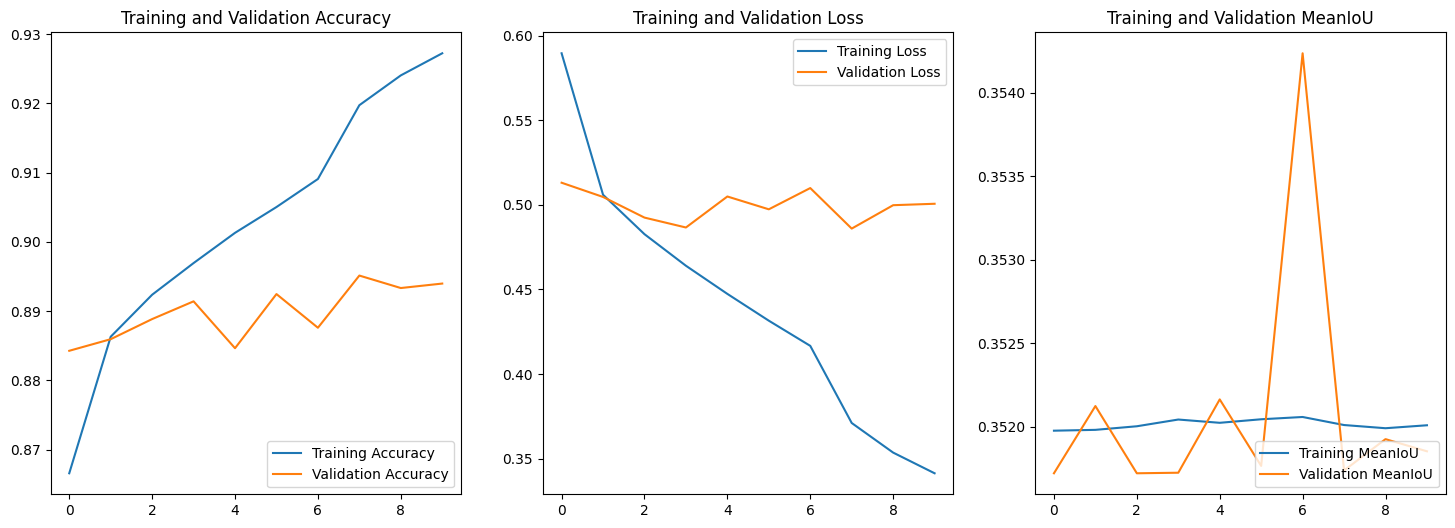

In [11]:
print("--- 7. Plotting Training History (Fine-Tuning Stage) ---")

acc = history.history.get('binary_accuracy', [])
val_acc = history.history.get('val_binary_accuracy', [])
loss = history.history.get('loss', [])
val_loss = history.history.get('val_loss', [])
iou = history.history.get('mean_io_u', [])
val_iou = history.history.get('val_mean_io_u', [])

epochs_range = range(len(loss))

plt.figure(figsize=(18, 6))

# Accuracy
plt.subplot(1, 3, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 3, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# IoU
plt.subplot(1, 3, 3)
plt.plot(epochs_range, iou, label='Training MeanIoU')
plt.plot(epochs_range, val_iou, label='Validation MeanIoU')
plt.legend(loc='lower right')
plt.title('Training and Validation MeanIoU')

plt.show()

--- 8. Visualizing Model Predictions (ResNet50) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


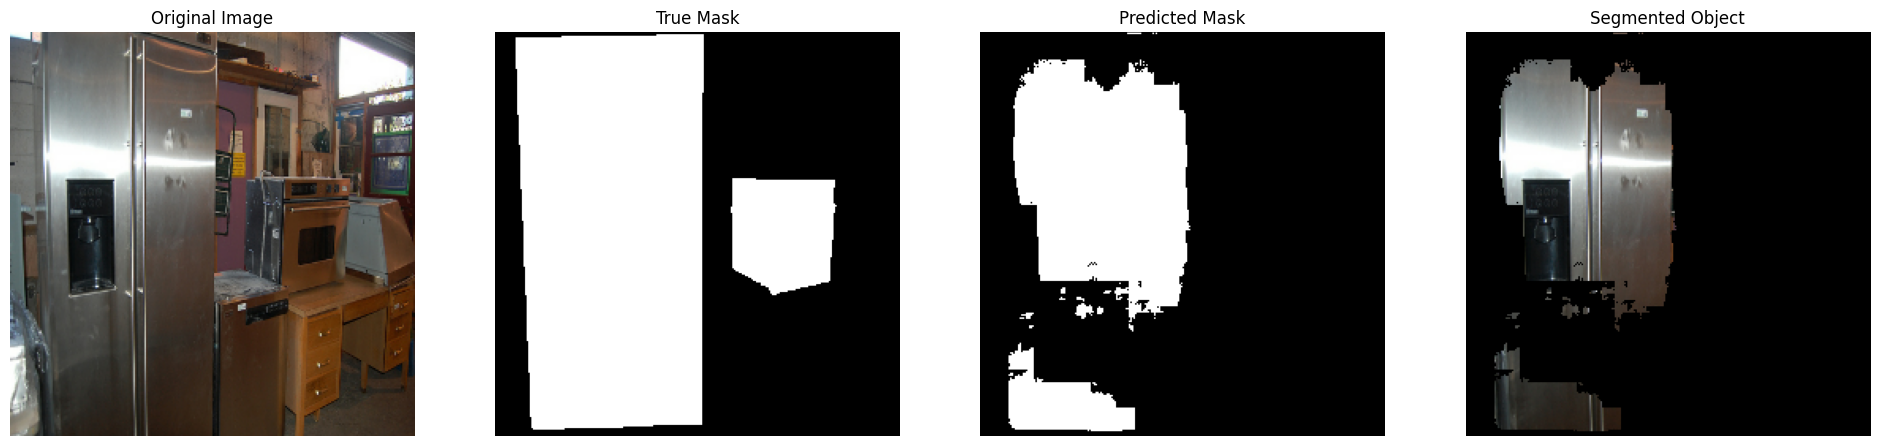

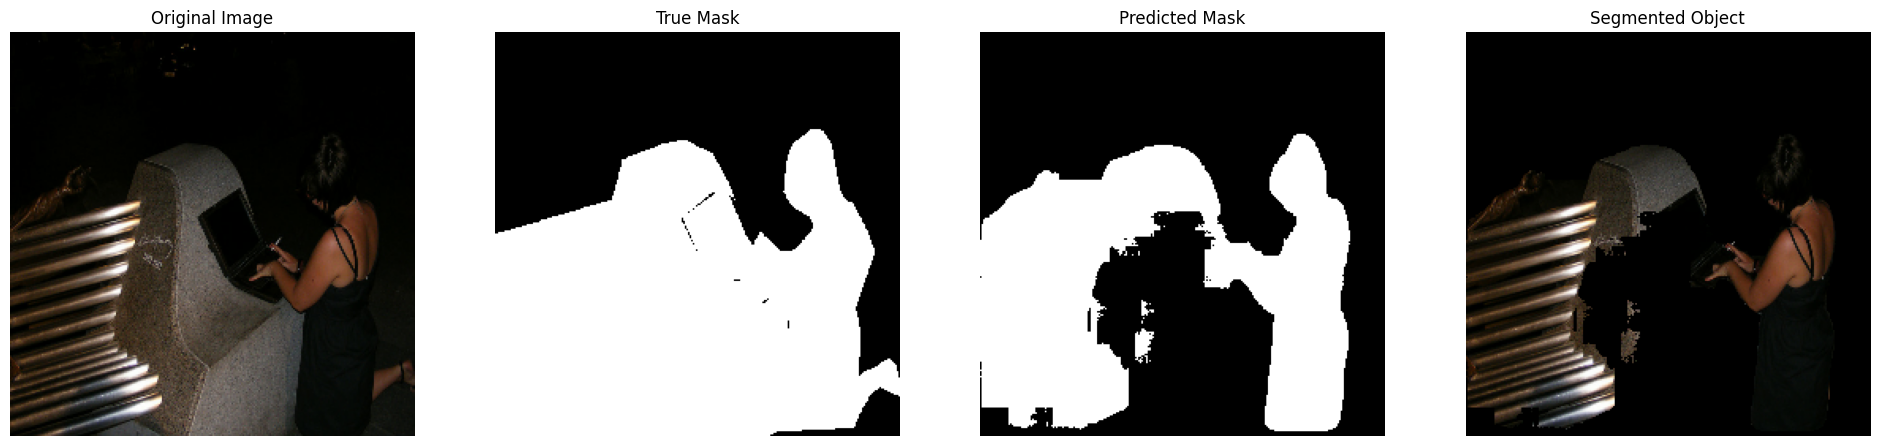

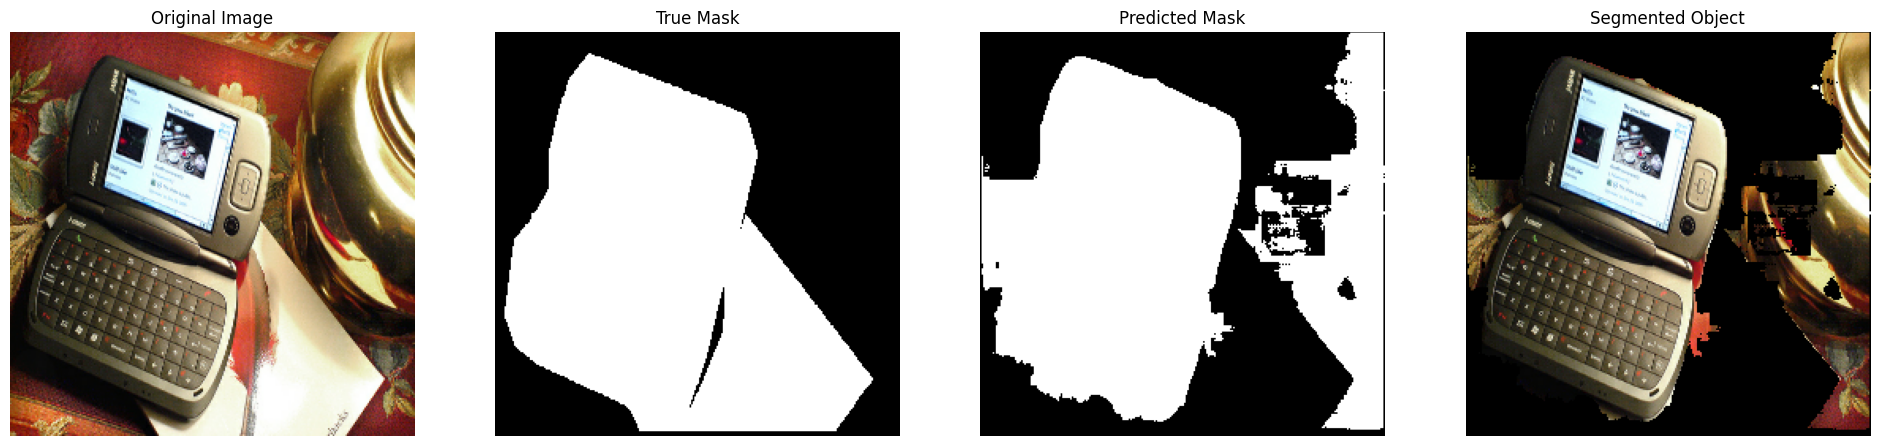

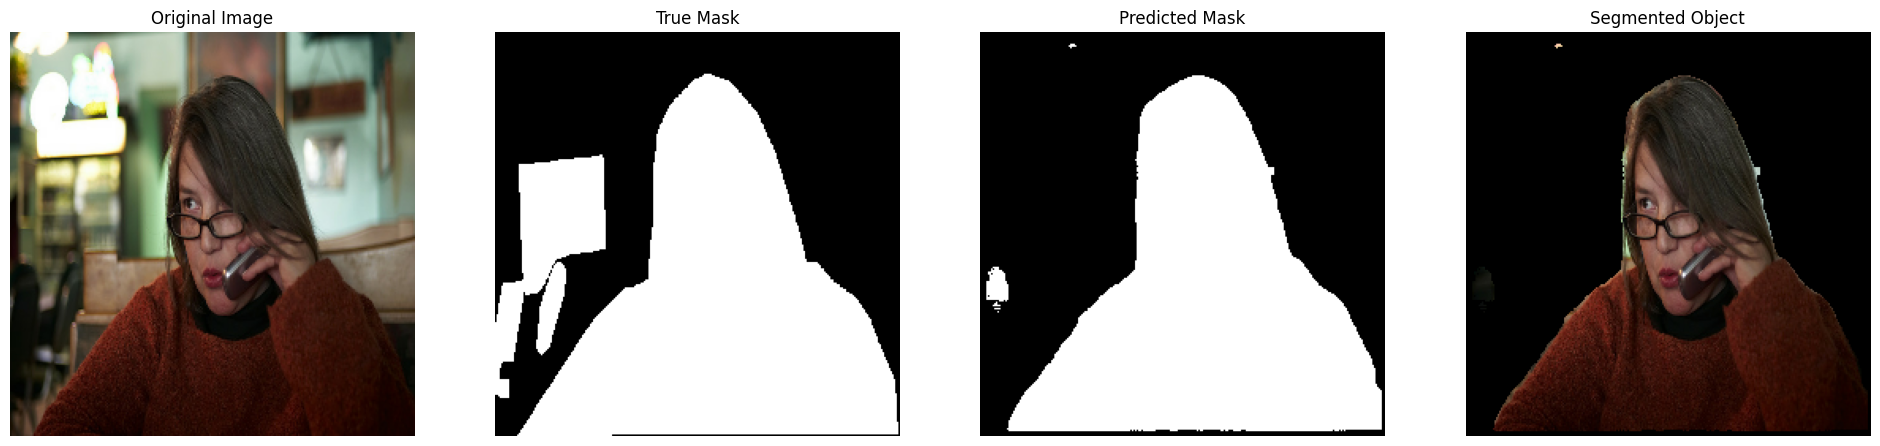

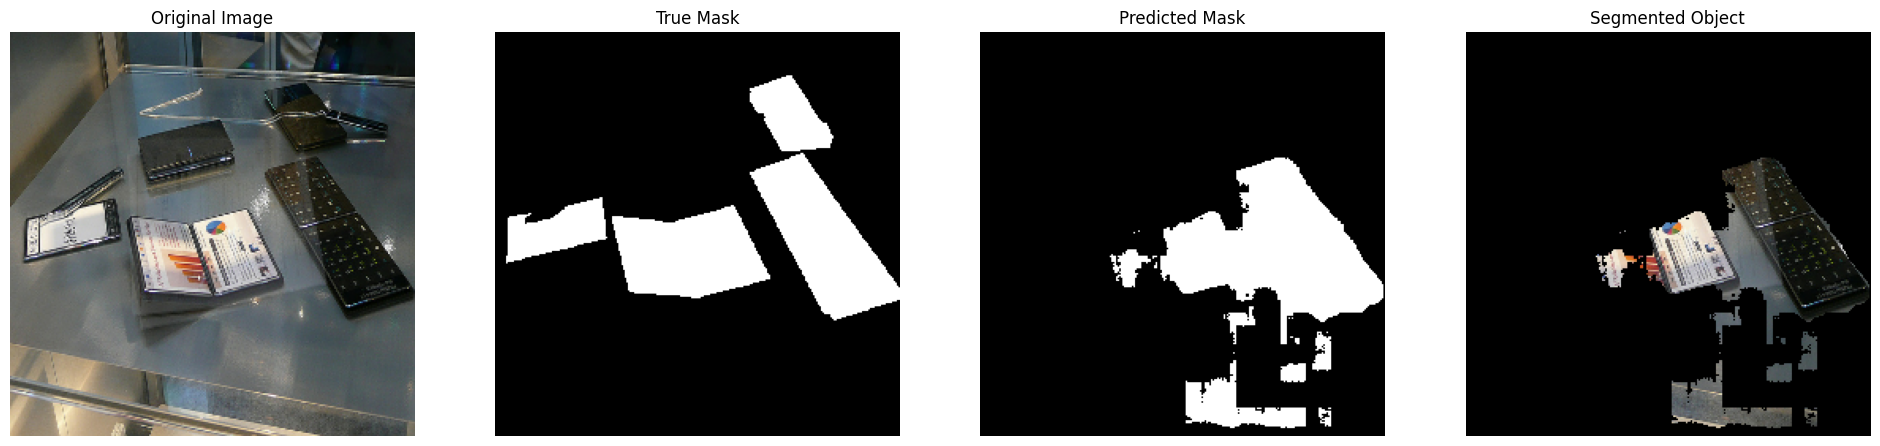

In [12]:
print("--- 8. Visualizing Model Predictions (ResNet50) ---")

def deprocess_resnet_image(image):
    # ResNet50 preprocess_input converts RGB to BGR and zero-centers 
    # each color channel with respect to the ImageNet dataset.
    # We need to reverse this to display the image correctly.
    img = image.copy()
    # Mean values for ImageNet (standard for Keras ResNet)
    img[..., 0] += 103.939
    img[..., 1] += 116.779
    img[..., 2] += 123.68
    # Convert BGR back to RGB
    img = img[..., ::-1]
    return np.clip(img, 0, 255).astype(np.uint8)

# Take one batch from the validation pipeline
for images, masks in val_pipeline.take(1):
    predictions = model.predict(images)
    
    # Display 5 predictions
    for i in range(5):
        if i >= len(images): break 
            
        # 1. Prepare Original Image
        display_image = deprocess_resnet_image(images[i].numpy())
        
        # 2. Prepare Binary Mask Prediction
        pred_mask_binary = (predictions[i] > 0.5).astype(np.uint8)
        
        # 3. Create "Segmented Object" (Color on Black)
        segmented_object = np.where(pred_mask_binary == 1, display_image, 0)
        
        # --- Plotting ---
        fig, ax = plt.subplots(1, 4, figsize=(24, 6))
        
        # Original
        ax[0].imshow(display_image)
        ax[0].set_title("Original Image")
        ax[0].axis('off')
        
        # True Mask
        ax[1].imshow(masks[i], cmap='gray')
        ax[1].set_title("True Mask")
        ax[1].axis('off')
        
        # Predicted Mask
        ax[2].imshow(pred_mask_binary, cmap='gray')
        ax[2].set_title("Predicted Mask")
        ax[2].axis('off')
        
        # Color Segmentation
        ax[3].imshow(segmented_object)
        ax[3].set_title("Segmented Object")
        ax[3].axis('off')
        
        plt.show()